In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import microlensing_calculations
from urllib.request import urlretrieve
import os
import ogle_utils
from astropy.table import Table

In [2]:
# Load file, downloading first if needed
def get_table(file_name, location='data/apjsab426b/',
                     url_base='https://content.cld.iop.org/journals/0067-0049/244/2/29/revision1/'):
    try:
        data = Table.read(location+file_name, format="ascii.cds")
    except:
        if not os.path.isdir(location):
            os.mkdir(location)
        urlretrieve(url_base+file_name, location+file_name)
        data = Table.read(location+file_name, format="ascii.cds")
    return data

In [4]:
# Fetch OGLE data if needed
ogle_surfdens = get_table('apjsab426bt5_mrt.txt').to_pandas(index='field')
ogle_fields = get_table('apjsab426bt6_mrt.txt').to_pandas(index='field')
ogle_rates = get_table('apjsab426bt7_mrt.txt').to_pandas(index='field')
# Store RA/Dec in rates table to get everything in one place
ogle_rates['RAdeg'] = ogle_fields['RAdeg']
ogle_rates['DEdeg'] = ogle_fields['DEdeg']

In [5]:
ogle_rates

,GLON,GLAT,tau,e_tau,gam,e_gam,gam-deg2,e_gam-deg2,tE-mean,e_tE-mean,Nevents,Nstars,RAdeg,DEdeg
field,,,,,,,,,,,,,,
BLG500,0.9999,-1.0293,1.93,0.21,23.9,2.0,168.8,13.7,18.8,1.6,164,6.78,267.9992,-28.6097
BLG501,-0.0608,-1.6400,2.13,0.15,24.1,1.4,222.9,12.9,20.5,1.1,317,13.31,267.9821,-29.8333
BLG502,-3.2832,-3.4735,1.22,0.12,11.0,0.9,69.7,5.5,25.7,1.8,171,10.02,267.9125,-33.5375
BLG503,-4.3547,-4.0831,0.74,0.10,5.5,0.7,37.4,4.2,31.4,3.3,91,10.70,267.8917,-34.7681
BLG504,2.1491,-1.7747,1.45,0.12,16.9,1.2,134.3,9.1,20.0,1.2,225,11.86,269.3888,-27.9944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLG710,5.3429,-15.0054,0.63,0.63,2.6,2.6,1.0,1.0,56.0,56.0,1,0.59,284.6292,-31.0764
BLG711,6.3893,-15.8210,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.48,285.9583,-30.4611
BLG714,2.4794,2.8944,1.24,0.20,11.0,1.7,41.6,6.6,26.4,3.6,54,5.84,265.1000,-25.3069


In [27]:
ogle_rates.sort_values('GLAT',inplace=True)
ogle_rates['in_lims'] = ((np.abs(ogle_rates['GLON'])<10) & (ogle_rates['GLAT']<5) & (ogle_rates['GLAT']>-10))
ogle_rates['use_for_latdep'] = ((np.abs(ogle_rates['GLON'])<3) & (ogle_rates['Nevents']>1) & (np.abs(ogle_rates['GLAT'])>0.7))

(-8.5, 6.5)

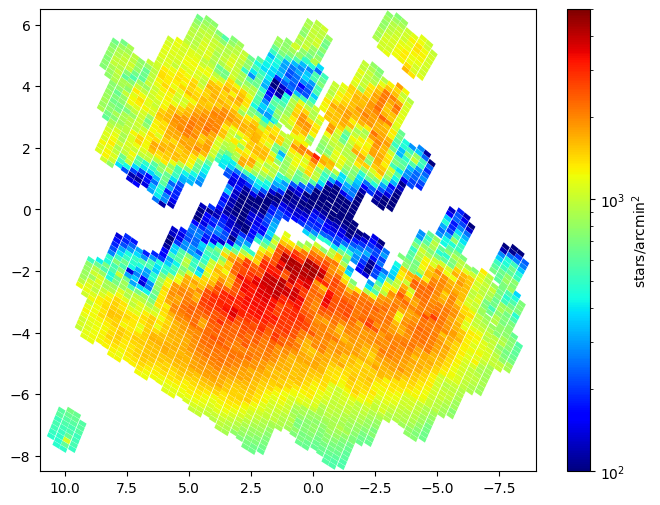

In [7]:
fig,ax=plt.subplots(figsize=(8,6))
patches=[]
sf_cols = []
for idx in ogle_rates.index:
    f,ra,dec=idx, ogle_rates['RAdeg'][idx],ogle_rates['DEdeg'][idx],
    for j in range(1,33):
        sbf_name = f+'.'+str(j).zfill(2)
        p = Polygon(np.column_stack(ogle_utils.equatorial_to_galactic(*ogle_utils.o4_subfield(ra,dec,j))),closed=True)
        try:
            dat = ogle_surfdens.at[sbf_name, 'sigma21']
            patches.append(p)
            sf_cols.append(dat)
        except:
            pass
norm = colors.LogNorm(vmin=100, vmax=5000)
pc = PatchCollection(patches, cmap='jet', norm=norm)
pc.set_array(sf_cols)
pc.set_edgecolor('none')
ax.add_collection(pc)

cbar = plt.colorbar(pc,label=r'stars/arcmin$^2$')
plt.xlim(11,-9)
plt.ylim(-8.5,6.5)

In [15]:
pts = ogle_rates[['GLON','GLAT']][ogle_rates['use_for_latdep']].sort_values('GLAT')

In [16]:
generate_catalogs = True

if generate_catalogs:
    import synthpop as sp
    sp_lens = sp.SynthPop(default_config='huston2025_defaults.synthpop_conf',
                          model_name="Huston2025", name_for_output='lens',
                         maglim=['Bessell_I', 21,"keep"], output_location="outputfiles/ogle",
                         extinction_map_kwargs={"name":"surot"})
    sp_src  = sp.SynthPop(default_config='huston2025_defaults.synthpop_conf',
                          model_name="Huston2025", name_for_output='src',
                         maglim=['Bessell_I', 21,"remove"], output_location="outputfiles/ogle",
                         extinction_map_kwargs={"name":"surot"})
    sp_lens.init_populations()
    sp_src.init_populations()
    
    ulim = 20000
    llim = 8000
    alim = 12000
    solang = 4e-4
    for pt in range(len(pts)):
        l,b=pts['GLON'][pt], pts['GLAT'][pt]
        df1,_ = sp_lens.process_location(l_deg=l, b_deg=b, solid_angle=solang)
        leng = len(df1)
        if leng>ulim or leng<llim:
            print('    length:',leng,", rerunning l=",l,' b=',b)
            solang = solang * alim/leng
            df1,_ = sp_lens.process_location(l_deg=l, b_deg=b, solid_angle=solang)
            leng = len(df1)
        solang = solang * alim/leng
        
    for pt in range(len(pts)):
        l,b=pts['GLON'][pt], pts['GLAT'][pt]
        df1,_ = sp_src.process_location(l_deg=l, b_deg=b, solid_angle=solang)
        leng = len(np.array(df1['W146']))
        if leng>ulim or leng<llim:
            print('    length:',leng,", rerunning l=",l,' b=',b)
            solang = solang * alim/leng
            df1,_ = sp_src.process_location(l_deg=l, b_deg=b, solid_angle=solang)
            leng = len(np.array(df1['W146']))
        solang = solang * alim/leng



################################ Settings #################################
 1975153 - # reading default parameters from
 1975155 - default_config_file =  /Users/mhuston/Documents/synthpop/synthpop/config_files/huston2025_defaults.synthpop_conf 


# copy the following to a config file to redo this model generation -------
 1975157 - {
    "l_set": null,
    "l_set_type": null,
    "b_set": null,
    "b_set_type": null,
    "random_seed": 846956542,
    "name_for_output": "lens",
    "model_name": "Huston2025",
    "solid_angle": null,
    "solid_angle_unit": "deg^2",
    "sun": {
        "x": -8.178,
        "y": 0.0,
        "z": 0.017,
        "u": 12.9,
        "v": 245.6,
        "w": 7.78,
        "l_apex_deg": 56.24,
        "b_apex_deg": 22.54
    },
    "lsr": {
        "u_lsr": 1.8,
        "v_lsr": 233.4,
        "w_lsr": 0.53
    },
    "warp": {
        "r_warp": 7.72,
        "amp_warp": 0.06,
        "amp_warp_pos": null,
        "amp_warp_neg": null,
        "alpha_war

    length: 7382 , rerunning l= 0.0082  b= 5.4341




# Population 0;  bulge ----------------------------------------------------
 2298702 - # From density profile (number density)
 2298703 - expected_total_iMass = 6503.7675
 2298703 - expected_total_eMass = 3580.1824
 2298703 - average_iMass_per_star = 0.5739
 2298703 - mass_loss_correction = 0.5505
 2298704 - n_expected_stars = 11333.2520
 2298704 - # Determine velocities when position are generated 
 2299174 - # From Generated Field:
 2299174 - generated_stars = 11247
 2299174 - generated_total_iMass = 6393.8233
 2299178 - generated_total_eMass = 3496.7659
 2299179 - det_mass_loss_corr = 0.5469
 2299186 - # Done


# Population 1;  halo -----------------------------------------------------
 2299542 - # From density profile (number density)
 2299543 - expected_total_iMass = 17.3631
 2299543 - expected_total_eMass = 9.1260
 2299543 - average_iMass_per_star = 0.5739
 2299543 - mass_loss_correction = 0.5256
 2299544 - n_expected_stars = 30.2564
 2299544 - # Determine velocities when posit

    length: 356 , rerunning l= -0.9252  b= -7.7037




# Population 0;  bulge ----------------------------------------------------
 2320600 - # From density profile (number density)
 2320601 - expected_total_iMass = 69649.9636
 2320601 - expected_total_eMass = 38168.2445
 2320602 - average_iMass_per_star = 0.5739
 2320602 - mass_loss_correction = 0.5480
 2320602 - n_expected_stars = 121369.7436
 2320603 - # Determine velocities when position are generated 
 2324304 - # From Generated Field:
 2324305 - generated_stars = 9537
 2324305 - generated_total_iMass = 7686.7075
 2324309 - generated_total_eMass = 7682.4655
 2324310 - det_mass_loss_corr = 0.9994
 2324316 - # Done


# Population 1;  halo -----------------------------------------------------
 2324625 - # From density profile (number density)
 2324625 - expected_total_iMass = 358.3594
 2324625 - expected_total_eMass = 189.5388
 2324625 - average_iMass_per_star = 0.5739
 2324626 - mass_loss_correction = 0.5289
 2324626 - n_expected_stars = 624.4653
 2324626 - # Determine velocities when

  0%|          | 0/271717 [00:00<?, ?it/s]

 2456653 - # From Generated Field:
 2456654 - generated_stars = 14751
 2456654 - generated_total_iMass = 12720.5597
 2456659 - generated_total_eMass = 12711.5363
 2456659 - det_mass_loss_corr = 0.9993
 2456668 - # Done


# Population 1;  halo -----------------------------------------------------
 2456982 - # From density profile (number density)
 2456982 - expected_total_iMass = 380.5912
 2456982 - expected_total_eMass = 201.2974
 2456983 - average_iMass_per_star = 0.5739
 2456983 - mass_loss_correction = 0.5289
 2456983 - n_expected_stars = 663.2058
 2456983 - # Determine velocities when position are generated 
 2457115 - # From Generated Field:
 2457116 - generated_stars = 33
 2457116 - generated_total_iMass = 22.0998
 2457119 - generated_total_eMass = 22.0887
 2457120 - det_mass_loss_corr = 0.9995
 2457124 - # Done


# Population 2;  nsd ------------------------------------------------------
 2458115 - # From density profile (number density)
 2458116 - expected_total_iMass = 0.0000


  0%|          | 0/316831 [00:00<?, ?it/s]

 2490437 - # From Generated Field:
 2490438 - generated_stars = 17666
 2490438 - generated_total_iMass = 15172.4911
 2490443 - generated_total_eMass = 15162.0350
 2490443 - det_mass_loss_corr = 0.9993
 2490455 - # Done


# Population 1;  halo -----------------------------------------------------
 2490806 - # From density profile (number density)
 2490806 - expected_total_iMass = 383.1886
 2490807 - expected_total_eMass = 202.6712
 2490807 - average_iMass_per_star = 0.5739
 2490807 - mass_loss_correction = 0.5289
 2490807 - n_expected_stars = 667.7320
 2490808 - # Determine velocities when position are generated 
 2490931 - # From Generated Field:
 2490931 - generated_stars = 28
 2490931 - generated_total_iMass = 18.4775
 2490934 - generated_total_eMass = 18.4714
 2490934 - det_mass_loss_corr = 0.9997
 2490938 - # Done


# Population 2;  nsd ------------------------------------------------------
 2491827 - # From density profile (number density)
 2491828 - expected_total_iMass = 0.0000


  0%|          | 0/303326 [00:00<?, ?it/s]

 2524615 - # From Generated Field:
 2524615 - generated_stars = 11547
 2524616 - generated_total_iMass = 10462.3364
 2524621 - generated_total_eMass = 10452.2277
 2524621 - det_mass_loss_corr = 0.9990
 2524628 - # Done


# Population 1;  halo -----------------------------------------------------
 2524945 - # From density profile (number density)
 2524945 - expected_total_iMass = 332.3841
 2524946 - expected_total_eMass = 175.8003
 2524946 - average_iMass_per_star = 0.5739
 2524946 - mass_loss_correction = 0.5289
 2524946 - n_expected_stars = 579.2016
 2524947 - # Determine velocities when position are generated 
 2525069 - # From Generated Field:
 2525069 - generated_stars = 20
 2525070 - generated_total_iMass = 13.6558
 2525073 - generated_total_eMass = 13.6502
 2525073 - det_mass_loss_corr = 0.9996
 2525077 - # Done


# Population 2;  nsd ------------------------------------------------------
 2526032 - # From density profile (number density)
 2526032 - expected_total_iMass = 0.0000


  0%|          | 0/358964 [00:00<?, ?it/s]

 2544900 - # From Generated Field:
 2544900 - generated_stars = 19713
 2544901 - generated_total_iMass = 16972.8965
 2544905 - generated_total_eMass = 16961.2839
 2544906 - det_mass_loss_corr = 0.9993
 2544915 - # Done


# Population 1;  halo -----------------------------------------------------
 2545220 - # From density profile (number density)
 2545221 - expected_total_iMass = 394.1704
 2545221 - expected_total_eMass = 208.4795
 2545221 - average_iMass_per_star = 0.5739
 2545222 - mass_loss_correction = 0.5289
 2545222 - n_expected_stars = 686.8684
 2545222 - # Determine velocities when position are generated 
 2545346 - # From Generated Field:
 2545346 - generated_stars = 24
 2545347 - generated_total_iMass = 16.0557
 2545350 - generated_total_eMass = 16.0502
 2545350 - det_mass_loss_corr = 0.9997
 2545354 - # Done


# Population 2;  nsd ------------------------------------------------------
 2546270 - # From density profile (number density)
 2546271 - expected_total_iMass = 0.0000


    length: 21469 , rerunning l= 1.1399  b= -3.7432




# Population 0;  bulge ----------------------------------------------------
 2553803 - # From density profile (number density)
 2553804 - expected_total_iMass = 114850.3847
 2553804 - expected_total_eMass = 62938.1171
 2553804 - average_iMass_per_star = 0.5739
 2553804 - mass_loss_correction = 0.5480
 2553805 - n_expected_stars = 200134.5158
 2553805 - # Determine velocities when position are generated 
 2560210 - # From Generated Field:
 2560211 - generated_stars = 10933
 2560211 - generated_total_iMass = 9400.1766
 2560217 - generated_total_eMass = 9393.2395
 2560217 - det_mass_loss_corr = 0.9993
 2560224 - # Done


# Population 1;  halo -----------------------------------------------------
 2560534 - # From density profile (number density)
 2560534 - expected_total_iMass = 220.3237
 2560535 - expected_total_eMass = 116.5308
 2560535 - average_iMass_per_star = 0.5739
 2560535 - mass_loss_correction = 0.5289
 2560536 - n_expected_stars = 383.9288
 2560536 - # Determine velocities wh

    length: 6937 , rerunning l= -1.0641  b= -3.6101




# Population 0;  bulge ----------------------------------------------------
 2584287 - # From density profile (number density)
 2584287 - expected_total_iMass = 221809.6187
 2584288 - expected_total_eMass = 121551.8763
 2584288 - average_iMass_per_star = 0.5739
 2584288 - mass_loss_correction = 0.5480
 2584289 - n_expected_stars = 386518.1711
 2584289 - # Determine velocities when position are generated 


  0%|          | 0/386862 [00:00<?, ?it/s]

 2596543 - # From Generated Field:
 2596544 - generated_stars = 11015
 2596544 - generated_total_iMass = 10272.2306
 2596549 - generated_total_eMass = 10260.7233
 2596549 - det_mass_loss_corr = 0.9989
 2596556 - # Done


# Population 1;  halo -----------------------------------------------------
 2596864 - # From density profile (number density)
 2596864 - expected_total_iMass = 403.6506
 2596865 - expected_total_eMass = 213.4937
 2596865 - average_iMass_per_star = 0.5739
 2596865 - mass_loss_correction = 0.5289
 2596865 - n_expected_stars = 703.3883
 2596865 - # Determine velocities when position are generated 
 2596992 - # From Generated Field:
 2596992 - generated_stars = 6
 2596993 - generated_total_iMass = 4.1762
 2596996 - generated_total_eMass = 4.1746
 2596996 - det_mass_loss_corr = 0.9996
 2597000 - # Done


# Population 2;  nsd ------------------------------------------------------
 2597904 - # From density profile (number density)
 2597905 - expected_total_iMass = 0.0000
 25

  0%|          | 0/419346 [00:00<?, ?it/s]

 2617977 - # From Generated Field:
 2617978 - generated_stars = 19978
 2617978 - generated_total_iMass = 17574.9597
 2617983 - generated_total_eMass = 17560.3918
 2617983 - det_mass_loss_corr = 0.9992
 2617993 - # Done


# Population 1;  halo -----------------------------------------------------
 2618441 - # From density profile (number density)
 2618442 - expected_total_iMass = 421.4774
 2618442 - expected_total_eMass = 222.9224
 2618442 - average_iMass_per_star = 0.5739
 2618442 - mass_loss_correction = 0.5289
 2618443 - n_expected_stars = 734.4527
 2618443 - # Determine velocities when position are generated 
 2618577 - # From Generated Field:
 2618577 - generated_stars = 33
 2618578 - generated_total_iMass = 22.6856
 2618581 - generated_total_eMass = 22.6769
 2618581 - det_mass_loss_corr = 0.9996
 2618585 - # Done


# Population 2;  nsd ------------------------------------------------------
 2619518 - # From density profile (number density)
 2619518 - expected_total_iMass = 0.0100


    length: 22124 , rerunning l= 2.2154  b= -3.1355




# Population 0;  bulge ----------------------------------------------------
 2627869 - # From density profile (number density)
 2627870 - expected_total_iMass = 130663.2667
 2627870 - expected_total_eMass = 71603.5911
 2627870 - average_iMass_per_star = 0.5739
 2627871 - mass_loss_correction = 0.5480
 2627871 - n_expected_stars = 227689.5257
 2627871 - # Determine velocities when position are generated 
 2634876 - # From Generated Field:
 2634876 - generated_stars = 10725
 2634877 - generated_total_iMass = 9412.9097
 2634882 - generated_total_eMass = 9405.1113
 2634883 - det_mass_loss_corr = 0.9992
 2634889 - # Done


# Population 1;  halo -----------------------------------------------------
 2635247 - # From density profile (number density)
 2635247 - expected_total_iMass = 228.6186
 2635248 - expected_total_eMass = 120.9180
 2635248 - average_iMass_per_star = 0.5739
 2635248 - mass_loss_correction = 0.5289
 2635249 - n_expected_stars = 398.3832
 2635249 - # Determine velocities wh

  0%|          | 0/280180 [00:00<?, ?it/s]

 2652063 - # From Generated Field:
 2652064 - generated_stars = 7363
 2652064 - generated_total_iMass = 6924.6036
 2652068 - generated_total_eMass = 6915.6593
 2652069 - det_mass_loss_corr = 0.9987
 2652074 - # Done


# Population 1;  halo -----------------------------------------------------
 2652399 - # From density profile (number density)
 2652399 - expected_total_iMass = 294.5681
 2652400 - expected_total_eMass = 155.7992
 2652400 - average_iMass_per_star = 0.5739
 2652400 - mass_loss_correction = 0.5289
 2652400 - n_expected_stars = 513.3047
 2652401 - # Determine velocities when position are generated 
 2652519 - # From Generated Field:
 2652520 - generated_stars = 10
 2652520 - generated_total_iMass = 7.2871
 2652523 - generated_total_eMass = 7.2819
 2652523 - det_mass_loss_corr = 0.9993
 2652527 - # Done


# Population 2;  nsd ------------------------------------------------------
 2653479 - # From density profile (number density)
 2653479 - expected_total_iMass = 0.0998
 2653

  0%|          | 0/418375 [00:00<?, ?it/s]

 2674401 - # From Generated Field:
 2674401 - generated_stars = 6435
 2674402 - generated_total_iMass = 6295.3277
 2674406 - generated_total_eMass = 6283.5557
 2674406 - det_mass_loss_corr = 0.9981
 2674413 - # Done


# Population 1;  halo -----------------------------------------------------
 2674780 - # From density profile (number density)
 2674780 - expected_total_iMass = 372.0716
 2674780 - expected_total_eMass = 196.7913
 2674780 - average_iMass_per_star = 0.5739
 2674781 - mass_loss_correction = 0.5289
 2674781 - n_expected_stars = 648.3597
 2674781 - # Determine velocities when position are generated 
 2674905 - # From Generated Field:
 2674905 - generated_stars = 10
 2674905 - generated_total_iMass = 7.2665
 2674908 - generated_total_eMass = 7.2544
 2674909 - det_mass_loss_corr = 0.9983
 2674913 - # Done


# Population 2;  nsd ------------------------------------------------------
 2675984 - # From density profile (number density)
 2675985 - expected_total_iMass = 0.5469
 2675

    length: 7462 , rerunning l= -2.2129  b= -2.8632




# Population 0;  bulge ----------------------------------------------------
 2684296 - # From density profile (number density)
 2684297 - expected_total_iMass = 386343.8394
 2684297 - expected_total_eMass = 211716.7816
 2684298 - average_iMass_per_star = 0.5739
 2684298 - mass_loss_correction = 0.5480
 2684298 - n_expected_stars = 673230.1112
 2684299 - # Determine velocities when position are generated 


  0%|          | 0/674049 [00:00<?, ?it/s]

 2705002 - # From Generated Field:
 2705003 - generated_stars = 10262
 2705003 - generated_total_iMass = 10037.7743
 2705007 - generated_total_eMass = 10019.5700
 2705008 - det_mass_loss_corr = 0.9982
 2705030 - # Done


# Population 1;  halo -----------------------------------------------------
 2705350 - # From density profile (number density)
 2705350 - expected_total_iMass = 598.3529
 2705350 - expected_total_eMass = 316.4731
 2705350 - average_iMass_per_star = 0.5739
 2705351 - mass_loss_correction = 0.5289
 2705351 - n_expected_stars = 1042.6701
 2705351 - # Determine velocities when position are generated 
 2705494 - # From Generated Field:
 2705495 - generated_stars = 10
 2705495 - generated_total_iMass = 7.4465
 2705498 - generated_total_eMass = 7.4423
 2705498 - det_mass_loss_corr = 0.9994
 2705502 - # Done


# Population 2;  nsd ------------------------------------------------------
 2706411 - # From density profile (number density)
 2706411 - expected_total_iMass = 0.8864
 

  0%|          | 0/837176 [00:00<?, ?it/s]

 2742593 - # From Generated Field:
 2742594 - generated_stars = 30029
 2742594 - generated_total_iMass = 27390.6613
 2742599 - generated_total_eMass = 27364.4911
 2742600 - det_mass_loss_corr = 0.9990
 2742614 - # Done


# Population 1;  halo -----------------------------------------------------
 2742930 - # From density profile (number density)
 2742930 - expected_total_iMass = 866.6154
 2742931 - expected_total_eMass = 458.3590
 2742931 - average_iMass_per_star = 0.5739
 2742931 - mass_loss_correction = 0.5289
 2742931 - n_expected_stars = 1510.1355
 2742932 - # Determine velocities when position are generated 
 2743107 - # From Generated Field:
 2743107 - generated_stars = 44
 2743107 - generated_total_iMass = 30.9517
 2743111 - generated_total_eMass = 30.9622
 2743111 - det_mass_loss_corr = 1.0003
 2743115 - # Done


# Population 2;  nsd ------------------------------------------------------
 2744046 - # From density profile (number density)
 2744047 - expected_total_iMass = 24.574

    length: 33741 , rerunning l= 1.087  b= -2.389




# Population 0;  bulge ----------------------------------------------------
 2755415 - # From density profile (number density)
 2755416 - expected_total_iMass = 170951.0606
 2755416 - expected_total_eMass = 93681.3394
 2755416 - average_iMass_per_star = 0.5739
 2755416 - mass_loss_correction = 0.5480
 2755417 - n_expected_stars = 297893.7149
 2755417 - # Determine velocities when position are generated 


  0%|          | 0/297264 [00:00<?, ?it/s]

 2764836 - # From Generated Field:
 2764836 - generated_stars = 11170
 2764837 - generated_total_iMass = 10162.6290
 2764843 - generated_total_eMass = 10151.7089
 2764844 - det_mass_loss_corr = 0.9989
 2764851 - # Done


# Population 1;  halo -----------------------------------------------------
 2765157 - # From density profile (number density)
 2765157 - expected_total_iMass = 308.1073
 2765158 - expected_total_eMass = 162.9601
 2765158 - average_iMass_per_star = 0.5739
 2765158 - mass_loss_correction = 0.5289
 2765159 - n_expected_stars = 536.8977
 2765159 - # Determine velocities when position are generated 
 2765283 - # From Generated Field:
 2765284 - generated_stars = 25
 2765284 - generated_total_iMass = 17.3828
 2765287 - generated_total_eMass = 17.3742
 2765288 - det_mass_loss_corr = 0.9995
 2765292 - # Done


# Population 2;  nsd ------------------------------------------------------
 2766250 - # From density profile (number density)
 2766251 - expected_total_iMass = 8.7303


  0%|          | 0/321221 [00:00<?, ?it/s]

 2784287 - # From Generated Field:
 2784287 - generated_stars = 5236
 2784288 - generated_total_iMass = 5100.9356
 2784292 - generated_total_eMass = 5092.3220
 2784292 - det_mass_loss_corr = 0.9983
 2784297 - # Done


# Population 1;  halo -----------------------------------------------------
 2784598 - # From density profile (number density)
 2784598 - expected_total_iMass = 304.5446
 2784598 - expected_total_eMass = 161.0758
 2784598 - average_iMass_per_star = 0.5739
 2784599 - mass_loss_correction = 0.5289
 2784599 - n_expected_stars = 530.6895
 2784599 - # Determine velocities when position are generated 
 2784720 - # From Generated Field:
 2784721 - generated_stars = 7
 2784721 - generated_total_iMass = 5.2513
 2784724 - generated_total_eMass = 5.2154
 2784724 - det_mass_loss_corr = 0.9932
 2784728 - # Done


# Population 2;  nsd ------------------------------------------------------
 2785645 - # From density profile (number density)
 2785645 - expected_total_iMass = 13.9023
 2785

    length: 6162 , rerunning l= -1.1356  b= -2.2547




# Population 0;  bulge ----------------------------------------------------
 2793507 - # From density profile (number density)
 2793507 - expected_total_iMass = 359312.6145
 2793507 - expected_total_eMass = 196903.6453
 2793507 - average_iMass_per_star = 0.5739
 2793508 - mass_loss_correction = 0.5480
 2793508 - n_expected_stars = 626126.3846
 2793508 - # Determine velocities when position are generated 


  0%|          | 0/624503 [00:00<?, ?it/s]

 2813927 - # From Generated Field:
 2813927 - generated_stars = 9711
 2813928 - generated_total_iMass = 9494.3159
 2813932 - generated_total_eMass = 9477.0029
 2813932 - det_mass_loss_corr = 0.9982
 2813938 - # Done


# Population 1;  halo -----------------------------------------------------
 2814268 - # From density profile (number density)
 2814268 - expected_total_iMass = 593.0069
 2814269 - expected_total_eMass = 313.6456
 2814269 - average_iMass_per_star = 0.5739
 2814269 - mass_loss_correction = 0.5289
 2814270 - n_expected_stars = 1033.3544
 2814270 - # Determine velocities when position are generated 
 2814413 - # From Generated Field:
 2814414 - generated_stars = 16
 2814414 - generated_total_iMass = 12.0117
 2814418 - generated_total_eMass = 11.9679
 2814418 - det_mass_loss_corr = 0.9964
 2814423 - # Done


# Population 2;  nsd ------------------------------------------------------
 2815548 - # From density profile (number density)
 2815549 - expected_total_iMass = 27.1088
 

  0%|          | 0/644762 [00:00<?, ?it/s]

 2845754 - # From Generated Field:
 2845754 - generated_stars = 12006
 2845755 - generated_total_iMass = 11617.8325
 2845761 - generated_total_eMass = 11597.4927
 2845761 - det_mass_loss_corr = 0.9982
 2845768 - # Done


# Population 1;  halo -----------------------------------------------------
 2846064 - # From density profile (number density)
 2846064 - expected_total_iMass = 627.2213
 2846064 - expected_total_eMass = 331.7418
 2846065 - average_iMass_per_star = 0.5739
 2846065 - mass_loss_correction = 0.5289
 2846065 - n_expected_stars = 1092.9753
 2846065 - # Determine velocities when position are generated 
 2846204 - # From Generated Field:
 2846204 - generated_stars = 8
 2846204 - generated_total_iMass = 5.8834
 2846208 - generated_total_eMass = 5.8803
 2846208 - det_mass_loss_corr = 0.9995
 2846212 - # Done


# Population 2;  nsd ------------------------------------------------------
 2847283 - # From density profile (number density)
 2847283 - expected_total_iMass = 104.6199


  0%|          | 0/731676 [00:00<?, ?it/s]

 2881578 - # From Generated Field:
 2881578 - generated_stars = 12457
 2881579 - generated_total_iMass = 12110.1572
 2881583 - generated_total_eMass = 12087.7956
 2881583 - det_mass_loss_corr = 0.9982
 2881590 - # Done


# Population 1;  halo -----------------------------------------------------
 2881899 - # From density profile (number density)
 2881899 - expected_total_iMass = 601.2838
 2881900 - expected_total_eMass = 318.0232
 2881900 - average_iMass_per_star = 0.5739
 2881900 - mass_loss_correction = 0.5289
 2881900 - n_expected_stars = 1047.7774
 2881901 - # Determine velocities when position are generated 
 2882033 - # From Generated Field:
 2882033 - generated_stars = 15
 2882033 - generated_total_iMass = 10.6600
 2882036 - generated_total_eMass = 10.6662
 2882037 - det_mass_loss_corr = 1.0006
 2882041 - # Done


# Population 2;  nsd ------------------------------------------------------
 2882945 - # From density profile (number density)
 2882946 - expected_total_iMass = 521.24

  0%|          | 0/700672 [00:00<?, ?it/s]

 2916647 - # From Generated Field:
 2916647 - generated_stars = 1038
 2916648 - generated_total_iMass = 1068.3532
 2916652 - generated_total_eMass = 1052.0123
 2916652 - det_mass_loss_corr = 0.9847
 2916658 - # Done


# Population 1;  halo -----------------------------------------------------
 2916964 - # From density profile (number density)
 2916965 - expected_total_iMass = 507.2132
 2916965 - expected_total_eMass = 268.2687
 2916965 - average_iMass_per_star = 0.5739
 2916966 - mass_loss_correction = 0.5289
 2916966 - n_expected_stars = 883.8531
 2916966 - # Determine velocities when position are generated 
 2917094 - # From Generated Field:
 2917095 - generated_stars = 2
 2917095 - generated_total_iMass = 1.5468
 2917098 - generated_total_eMass = 1.5056
 2917098 - det_mass_loss_corr = 0.9734
 2917102 - # Done


# Population 2;  nsd ------------------------------------------------------
 2918062 - # From density profile (number density)
 2918063 - expected_total_iMass = 4381.4274
 29

    length: 2086 , rerunning l= 0.9999  b= -1.0293




# Population 0;  bulge ----------------------------------------------------
 2931601 - # From density profile (number density)
 2931602 - expected_total_iMass = 2312353.8648
 2931602 - expected_total_eMass = 1267172.0580
 2931603 - average_iMass_per_star = 0.5739
 2931603 - mass_loss_correction = 0.5480
 2931603 - n_expected_stars = 4029432.0515
 2931603 - # Determine velocities when position are generated 


  0%|          | 0/4033346 [00:00<?, ?it/s]

 3058427 - # From Generated Field:
 3058428 - generated_stars = 6172
 3058428 - generated_total_iMass = 6359.1806
 3058432 - generated_total_eMass = 6272.9995
 3058433 - det_mass_loss_corr = 0.9864
 3058438 - # Done


# Population 1;  halo -----------------------------------------------------
 3058738 - # From density profile (number density)
 3058738 - expected_total_iMass = 2918.0058
 3058738 - expected_total_eMass = 1543.3539
 3058738 - average_iMass_per_star = 0.5739
 3058738 - mass_loss_correction = 0.5289
 3058739 - n_expected_stars = 5084.8213
 3058739 - # Determine velocities when position are generated 
 3059011 - # From Generated Field:
 3059012 - generated_stars = 5
 3059012 - generated_total_iMass = 3.8677
 3059015 - generated_total_eMass = 3.7486
 3059015 - det_mass_loss_corr = 0.9692
 3059019 - # Done


# Population 2;  nsd ------------------------------------------------------
 3059930 - # From density profile (number density)
 3059930 - expected_total_iMass = 25300.9719

  0%|          | 0/302351 [00:00<?, ?it/s]

 3104268 - # From Generated Field:
 3104269 - generated_stars = 1924
 3104269 - generated_total_iMass = 1520.5040
 3104273 - generated_total_eMass = 1515.6462
 3104273 - det_mass_loss_corr = 0.9968
 3104278 - # Done


########################### Combine Populations ###########################
 3104281 - Number of stars generated: 12219 (41 columns)
 3104281 - remove stars which are outside of the isochrone grid 
 3104282 - cleand field: Number of stars generated: 12219 (41 columns)
 3104282 - included_columns = ['pop', 'iMass', 'age', 'Fe/H_initial', 'Mass', 'In_Final_Phase', 'Dist', 'l', 'b', 'vr_bc', 'mul', 'mub', 'x', 'y', 'z', 'U', 'V', 'W', 'VR_LSR', 'A_Ks', 'logL', 'logTeff', 'logg', 'Fe/H_evolved', 'log_radius', 'phase', 'R062', 'Z087', 'Y106', 'J129', 'W146', 'H158', 'F184', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', 'VISTA_J', 'VISTA_H', 'VISTA_Ks']


# Save result -------------------------------------------------------------
 3104291 - write result to "o

  0%|          | 0/3101938 [00:00<?, ?it/s]

 3203904 - # From Generated Field:
 3203904 - generated_stars = 8018
 3203905 - generated_total_iMass = 8176.2767
 3203909 - generated_total_eMass = 8103.7962
 3203909 - det_mass_loss_corr = 0.9911
 3203917 - # Done


# Population 1;  halo -----------------------------------------------------
 3204222 - # From density profile (number density)
 3204222 - expected_total_iMass = 2717.8155
 3204223 - expected_total_eMass = 1437.4719
 3204223 - average_iMass_per_star = 0.5739
 3204223 - mass_loss_correction = 0.5289
 3204223 - n_expected_stars = 4735.9762
 3204224 - # Determine velocities when position are generated 
 3204487 - # From Generated Field:
 3204488 - generated_stars = 10
 3204488 - generated_total_iMass = 7.6294
 3204491 - generated_total_eMass = 7.5499
 3204491 - det_mass_loss_corr = 0.9896
 3204495 - # Done


# Population 2;  nsd ------------------------------------------------------
 3205378 - # From density profile (number density)
 3205379 - expected_total_iMass = 13729.569

  0%|          | 0/344647 [00:00<?, ?it/s]

 3256645 - # From Generated Field:
 3256646 - generated_stars = 2425
 3256646 - generated_total_iMass = 1924.7810
 3256650 - generated_total_eMass = 1918.4494
 3256650 - det_mass_loss_corr = 0.9967
 3256655 - # Done


########################### Combine Populations ###########################
 3256659 - Number of stars generated: 15717 (41 columns)
 3256659 - remove stars which are outside of the isochrone grid 
 3256660 - cleand field: Number of stars generated: 15717 (41 columns)
 3256661 - included_columns = ['pop', 'iMass', 'age', 'Fe/H_initial', 'Mass', 'In_Final_Phase', 'Dist', 'l', 'b', 'vr_bc', 'mul', 'mub', 'x', 'y', 'z', 'U', 'V', 'W', 'VR_LSR', 'A_Ks', 'logL', 'logTeff', 'logg', 'Fe/H_evolved', 'log_radius', 'phase', 'R062', 'Z087', 'Y106', 'J129', 'W146', 'H158', 'F184', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', 'VISTA_J', 'VISTA_H', 'VISTA_Ks']


# Save result -------------------------------------------------------------
 3256673 - write result to "o

  0%|          | 0/2531727 [00:00<?, ?it/s]

 3338146 - # From Generated Field:
 3338146 - generated_stars = 6379
 3338146 - generated_total_iMass = 6520.9396
 3338150 - generated_total_eMass = 6463.8079
 3338151 - det_mass_loss_corr = 0.9912
 3338156 - # Done


# Population 1;  halo -----------------------------------------------------
 3338479 - # From density profile (number density)
 3338479 - expected_total_iMass = 1999.1540
 3338480 - expected_total_eMass = 1057.3667
 3338480 - average_iMass_per_star = 0.5739
 3338480 - mass_loss_correction = 0.5289
 3338480 - n_expected_stars = 3483.6603
 3338481 - # Determine velocities when position are generated 
 3338686 - # From Generated Field:
 3338686 - generated_stars = 10
 3338687 - generated_total_iMass = 7.6724
 3338690 - generated_total_eMass = 7.6614
 3338690 - det_mass_loss_corr = 0.9986
 3338694 - # Done


# Population 2;  nsd ------------------------------------------------------
 3339695 - # From density profile (number density)
 3339696 - expected_total_iMass = 1761.9080

  0%|          | 0/2547354 [00:00<?, ?it/s]

 3449313 - # From Generated Field:
 3449314 - generated_stars = 11067
 3449314 - generated_total_iMass = 11198.9697
 3449318 - generated_total_eMass = 11134.9457
 3449319 - det_mass_loss_corr = 0.9943
 3449326 - # Done


# Population 1;  halo -----------------------------------------------------
 3449627 - # From density profile (number density)
 3449628 - expected_total_iMass = 2208.0457
 3449628 - expected_total_eMass = 1167.8510
 3449628 - average_iMass_per_star = 0.5739
 3449629 - mass_loss_correction = 0.5289
 3449629 - n_expected_stars = 3847.6681
 3449629 - # Determine velocities when position are generated 
 3449878 - # From Generated Field:
 3449878 - generated_stars = 7
 3449878 - generated_total_iMass = 5.2246
 3449882 - generated_total_eMass = 5.2168
 3449882 - det_mass_loss_corr = 0.9985
 3449886 - # Done


# Population 2;  nsd ------------------------------------------------------
 3450764 - # From density profile (number density)
 3450765 - expected_total_iMass = 1170.30

  0%|          | 0/1759516 [00:00<?, ?it/s]

 3530732 - # From Generated Field:
 3530732 - generated_stars = 12314
 3530733 - generated_total_iMass = 12370.2077
 3530737 - generated_total_eMass = 12323.9774
 3530737 - det_mass_loss_corr = 0.9963
 3530744 - # Done


# Population 1;  halo -----------------------------------------------------
 3531060 - # From density profile (number density)
 3531060 - expected_total_iMass = 1597.2671
 3531061 - expected_total_eMass = 844.8059
 3531061 - average_iMass_per_star = 0.5739
 3531061 - mass_loss_correction = 0.5289
 3531061 - n_expected_stars = 2783.3452
 3531062 - # Determine velocities when position are generated 
 3531244 - # From Generated Field:
 3531245 - generated_stars = 4
 3531245 - generated_total_iMass = 2.8683
 3531248 - generated_total_eMass = 2.8667
 3531248 - det_mass_loss_corr = 0.9994
 3531252 - # Done


# Population 2;  nsd ------------------------------------------------------
 3532191 - # From density profile (number density)
 3532192 - expected_total_iMass = 182.1555

  0%|          | 0/1034107 [00:00<?, ?it/s]

 3581329 - # From Generated Field:
 3581329 - generated_stars = 9915
 3581330 - generated_total_iMass = 9879.9928
 3581335 - generated_total_eMass = 9853.5070
 3581335 - det_mass_loss_corr = 0.9973
 3581342 - # Done


# Population 1;  halo -----------------------------------------------------
 3581637 - # From density profile (number density)
 3581637 - expected_total_iMass = 1042.2345
 3581638 - expected_total_eMass = 551.2452
 3581638 - average_iMass_per_star = 0.5739
 3581638 - mass_loss_correction = 0.5289
 3581638 - n_expected_stars = 1816.1637
 3581639 - # Determine velocities when position are generated 
 3581813 - # From Generated Field:
 3581813 - generated_stars = 9
 3581814 - generated_total_iMass = 6.8522
 3581817 - generated_total_eMass = 6.8114
 3581817 - det_mass_loss_corr = 0.9940
 3581821 - # Done


# Population 2;  nsd ------------------------------------------------------
 3582776 - # From density profile (number density)
 3582777 - expected_total_iMass = 29.6987
 35

  0%|          | 0/936083 [00:00<?, ?it/s]

 3624419 - # From Generated Field:
 3624420 - generated_stars = 7855
 3624420 - generated_total_iMass = 7864.7490
 3624424 - generated_total_eMass = 7839.8184
 3624425 - det_mass_loss_corr = 0.9968
 3624438 - # Done


# Population 1;  halo -----------------------------------------------------
 3624760 - # From density profile (number density)
 3624761 - expected_total_iMass = 830.0370
 3624761 - expected_total_eMass = 439.0125
 3624761 - average_iMass_per_star = 0.5739
 3624761 - mass_loss_correction = 0.5289
 3624762 - n_expected_stars = 1446.3953
 3624762 - # Determine velocities when position are generated 
 3624925 - # From Generated Field:
 3624926 - generated_stars = 13
 3624926 - generated_total_iMass = 9.9298
 3624929 - generated_total_eMass = 9.9450
 3624929 - det_mass_loss_corr = 1.0015
 3624933 - # Done


# Population 2;  nsd ------------------------------------------------------
 3625849 - # From density profile (number density)
 3625849 - expected_total_iMass = 4.2288
 362

  0%|          | 0/1137287 [00:00<?, ?it/s]

 3672136 - # From Generated Field:
 3672137 - generated_stars = 24959
 3672137 - generated_total_iMass = 23866.7596
 3672144 - generated_total_eMass = 23831.3379
 3672144 - det_mass_loss_corr = 0.9985
 3672155 - # Done


# Population 1;  halo -----------------------------------------------------
 3672509 - # From density profile (number density)
 3672509 - expected_total_iMass = 1199.8771
 3672509 - expected_total_eMass = 634.6235
 3672509 - average_iMass_per_star = 0.5739
 3672510 - mass_loss_correction = 0.5289
 3672510 - n_expected_stars = 2090.8665
 3672510 - # Determine velocities when position are generated 
 3672681 - # From Generated Field:
 3672681 - generated_stars = 23
 3672682 - generated_total_iMass = 16.8793
 3672685 - generated_total_eMass = 16.8706
 3672685 - det_mass_loss_corr = 0.9995
 3672689 - # Done


# Population 2;  nsd ------------------------------------------------------
 3673583 - # From density profile (number density)
 3673584 - expected_total_iMass = 4.154

    length: 28026 , rerunning l= 0.3282  b= 2.8242




# Population 0;  bulge ----------------------------------------------------
 3685459 - # From density profile (number density)
 3685459 - expected_total_iMass = 279640.4494
 3685459 - expected_total_eMass = 153243.2251
 3685460 - average_iMass_per_star = 0.5739
 3685460 - mass_loss_correction = 0.5480
 3685460 - n_expected_stars = 487292.2813
 3685460 - # Determine velocities when position are generated 


  0%|          | 0/488083 [00:00<?, ?it/s]

 3700758 - # From Generated Field:
 3700759 - generated_stars = 10980
 3700759 - generated_total_iMass = 10480.2451
 3700763 - generated_total_eMass = 10465.7878
 3700764 - det_mass_loss_corr = 0.9986
 3700771 - # Done


# Population 1;  halo -----------------------------------------------------
 3701066 - # From density profile (number density)
 3701067 - expected_total_iMass = 513.8002
 3701067 - expected_total_eMass = 271.7525
 3701067 - average_iMass_per_star = 0.5739
 3701068 - mass_loss_correction = 0.5289
 3701068 - n_expected_stars = 895.3313
 3701068 - # Determine velocities when position are generated 
 3701206 - # From Generated Field:
 3701207 - generated_stars = 9
 3701207 - generated_total_iMass = 6.5741
 3701210 - generated_total_eMass = 6.5704
 3701211 - det_mass_loss_corr = 0.9994
 3701215 - # Done


# Population 2;  nsd ------------------------------------------------------
 3702138 - # From density profile (number density)
 3702138 - expected_total_iMass = 1.7619
 37

  0%|          | 0/385549 [00:00<?, ?it/s]

 3722831 - # From Generated Field:
 3722832 - generated_stars = 4508
 3722832 - generated_total_iMass = 4458.0760
 3722838 - generated_total_eMass = 4448.3692
 3722838 - det_mass_loss_corr = 0.9978
 3722843 - # Done


# Population 1;  halo -----------------------------------------------------
 3723206 - # From density profile (number density)
 3723206 - expected_total_iMass = 377.7956
 3723207 - expected_total_eMass = 199.8188
 3723207 - average_iMass_per_star = 0.5739
 3723207 - mass_loss_correction = 0.5289
 3723207 - n_expected_stars = 658.3342
 3723208 - # Determine velocities when position are generated 
 3723337 - # From Generated Field:
 3723337 - generated_stars = 5
 3723338 - generated_total_iMass = 3.2468
 3723341 - generated_total_eMass = 3.2448
 3723341 - det_mass_loss_corr = 0.9994
 3723345 - # Done


# Population 2;  nsd ------------------------------------------------------
 3724241 - # From density profile (number density)
 3724241 - expected_total_iMass = 0.3265
 37242

    length: 5380 , rerunning l= 2.4794  b= 2.8944




# Population 0;  bulge ----------------------------------------------------
 3732541 - # From density profile (number density)
 3732542 - expected_total_iMass = 492637.1669
 3732542 - expected_total_eMass = 269965.6234
 3732542 - average_iMass_per_star = 0.5739
 3732543 - mass_loss_correction = 0.5480
 3732543 - n_expected_stars = 858453.3796
 3732543 - # Determine velocities when position are generated 


  0%|          | 0/859471 [00:00<?, ?it/s]

 3759725 - # From Generated Field:
 3759726 - generated_stars = 10144
 3759726 - generated_total_iMass = 10053.6145
 3759733 - generated_total_eMass = 10030.7781
 3759733 - det_mass_loss_corr = 0.9977
 3759740 - # Done


# Population 1;  halo -----------------------------------------------------
 3760111 - # From density profile (number density)
 3760111 - expected_total_iMass = 842.6929
 3760111 - expected_total_eMass = 445.7063
 3760111 - average_iMass_per_star = 0.5739
 3760112 - mass_loss_correction = 0.5289
 3760112 - n_expected_stars = 1468.4491
 3760112 - # Determine velocities when position are generated 
 3760267 - # From Generated Field:
 3760267 - generated_stars = 17
 3760268 - generated_total_iMass = 12.9082
 3760271 - generated_total_eMass = 12.8554
 3760271 - det_mass_loss_corr = 0.9959
 3760275 - # Done


# Population 2;  nsd ------------------------------------------------------
 3761354 - # From density profile (number density)
 3761355 - expected_total_iMass = 0.7345

  0%|          | 0/815070 [00:00<?, ?it/s]

 3797804 - # From Generated Field:
 3797804 - generated_stars = 14356
 3797805 - generated_total_iMass = 13929.4682
 3797809 - generated_total_eMass = 13904.9257
 3797809 - det_mass_loss_corr = 0.9982
 3797818 - # Done


# Population 1;  halo -----------------------------------------------------
 3798122 - # From density profile (number density)
 3798122 - expected_total_iMass = 832.4954
 3798122 - expected_total_eMass = 440.3127
 3798123 - average_iMass_per_star = 0.5739
 3798123 - mass_loss_correction = 0.5289
 3798123 - n_expected_stars = 1450.6792
 3798123 - # Determine velocities when position are generated 
 3798276 - # From Generated Field:
 3798277 - generated_stars = 10
 3798277 - generated_total_iMass = 7.3069
 3798280 - generated_total_eMass = 7.3031
 3798281 - det_mass_loss_corr = 0.9995
 3798285 - # Done


# Population 2;  nsd ------------------------------------------------------
 3799359 - # From density profile (number density)
 3799359 - expected_total_iMass = 0.0000
 

  0%|          | 0/547815 [00:00<?, ?it/s]

 3826246 - # From Generated Field:
 3826246 - generated_stars = 1665
 3826246 - generated_total_iMass = 1697.5586
 3826251 - generated_total_eMass = 1685.1647
 3826251 - det_mass_loss_corr = 0.9927
 3826256 - # Done


# Population 1;  halo -----------------------------------------------------
 3826612 - # From density profile (number density)
 3826613 - expected_total_iMass = 585.0147
 3826613 - expected_total_eMass = 309.4184
 3826613 - average_iMass_per_star = 0.5739
 3826613 - mass_loss_correction = 0.5289
 3826614 - n_expected_stars = 1019.4274
 3826614 - # Determine velocities when position are generated 
 3826765 - # From Generated Field:
 3826765 - generated_stars = 1
 3826765 - generated_total_iMass = 0.7711
 3826768 - generated_total_eMass = 0.7701
 3826769 - det_mass_loss_corr = 0.9988
 3826773 - # Done


# Population 2;  nsd ------------------------------------------------------
 3827764 - # From density profile (number density)
 3827765 - expected_total_iMass = 0.0000
 3827

    length: 2296 , rerunning l= 1.3523  b= 3.4996




# Population 0;  bulge ----------------------------------------------------
 3835636 - # From density profile (number density)
 3835636 - expected_total_iMass = 1640193.5851
 3835637 - expected_total_eMass = 898827.6027
 3835637 - average_iMass_per_star = 0.5739
 3835637 - mass_loss_correction = 0.5480
 3835637 - n_expected_stars = 2858147.5799
 3835638 - # Determine velocities when position are generated 


  0%|          | 0/2858291 [00:00<?, ?it/s]

 3925381 - # From Generated Field:
 3925381 - generated_stars = 9261
 3925382 - generated_total_iMass = 9428.8928
 3925386 - generated_total_eMass = 9364.0568
 3925387 - det_mass_loss_corr = 0.9931
 3925394 - # Done


# Population 1;  halo -----------------------------------------------------
 3925694 - # From density profile (number density)
 3925694 - expected_total_iMass = 3057.6091
 3925694 - expected_total_eMass = 1617.1911
 3925694 - average_iMass_per_star = 0.5739
 3925695 - mass_loss_correction = 0.5289
 3925695 - n_expected_stars = 5328.0894
 3925695 - # Determine velocities when position are generated 
 3925992 - # From Generated Field:
 3925992 - generated_stars = 10
 3925993 - generated_total_iMass = 7.5867
 3925996 - generated_total_eMass = 7.5798
 3925996 - det_mass_loss_corr = 0.9991
 3926000 - # Done


# Population 2;  nsd ------------------------------------------------------
 3927044 - # From density profile (number density)
 3927045 - expected_total_iMass = 0.0000
 3

  0%|          | 0/2124378 [00:00<?, ?it/s]

 4010137 - # From Generated Field:
 4010137 - generated_stars = 42114
 4010138 - generated_total_iMass = 40555.7311
 4010144 - generated_total_eMass = 40490.4878
 4010144 - det_mass_loss_corr = 0.9984
 4010162 - # Done


# Population 1;  halo -----------------------------------------------------
 4010469 - # From density profile (number density)
 4010469 - expected_total_iMass = 2238.6079
 4010470 - expected_total_eMass = 1184.0155
 4010470 - average_iMass_per_star = 0.5739
 4010470 - mass_loss_correction = 0.5289
 4010470 - n_expected_stars = 3900.9247
 4010471 - # Determine velocities when position are generated 
 4010717 - # From Generated Field:
 4010718 - generated_stars = 41
 4010718 - generated_total_iMass = 30.0722
 4010722 - generated_total_eMass = 29.9853
 4010722 - det_mass_loss_corr = 0.9971
 4010726 - # Done


# Population 2;  nsd ------------------------------------------------------
 4011714 - # From density profile (number density)
 4011715 - expected_total_iMass = 0.00

    length: 47270 , rerunning l= -2.2382  b= 4.0765




# Population 0;  bulge ----------------------------------------------------
 4026519 - # From density profile (number density)
 4026520 - expected_total_iMass = 309507.9016
 4026520 - expected_total_eMass = 169610.6165
 4026520 - average_iMass_per_star = 0.5739
 4026521 - mass_loss_correction = 0.5480
 4026521 - n_expected_stars = 539338.3244
 4026521 - # Determine velocities when position are generated 


  0%|          | 0/540047 [00:00<?, ?it/s]

 4043903 - # From Generated Field:
 4043903 - generated_stars = 11254
 4043904 - generated_total_iMass = 10813.1305
 4043909 - generated_total_eMass = 10796.9310
 4043910 - det_mass_loss_corr = 0.9985
 4043919 - # Done


# Population 1;  halo -----------------------------------------------------
 4044241 - # From density profile (number density)
 4044242 - expected_total_iMass = 568.2240
 4044242 - expected_total_eMass = 300.5377
 4044242 - average_iMass_per_star = 0.5739
 4044242 - mass_loss_correction = 0.5289
 4044243 - n_expected_stars = 990.1685
 4044243 - # Determine velocities when position are generated 
 4044384 - # From Generated Field:
 4044385 - generated_stars = 11
 4044385 - generated_total_iMass = 7.8249
 4044388 - generated_total_eMass = 7.8212
 4044388 - det_mass_loss_corr = 0.9995
 4044393 - # Done


# Population 2;  nsd ------------------------------------------------------
 4045300 - # From density profile (number density)
 4045301 - expected_total_iMass = 0.0000
 4

  0%|          | 0/497597 [00:00<?, ?it/s]

 4069603 - # From Generated Field:
 4069603 - generated_stars = 953
 4069603 - generated_total_iMass = 981.3785
 4069608 - generated_total_eMass = 969.3876
 4069608 - det_mass_loss_corr = 0.9878
 4069614 - # Done


# Population 1;  halo -----------------------------------------------------
 4069923 - # From density profile (number density)
 4069923 - expected_total_iMass = 584.2296
 4069924 - expected_total_eMass = 309.0032
 4069924 - average_iMass_per_star = 0.5739
 4069924 - mass_loss_correction = 0.5289
 4069924 - n_expected_stars = 1018.0594
 4069925 - # Determine velocities when position are generated 
 4070059 - # From Generated Field:
 4070059 - generated_stars = 2
 4070059 - generated_total_iMass = 1.6416
 4070063 - generated_total_eMass = 1.6399
 4070063 - det_mass_loss_corr = 0.9989
 4070066 - # Done


# Population 2;  nsd ------------------------------------------------------
 4070998 - # From density profile (number density)
 4070998 - expected_total_iMass = 0.0000
 4070998

    length: 1384 , rerunning l= 0.1737  b= 4.1858




# Population 0;  bulge ----------------------------------------------------
 4078452 - # From density profile (number density)
 4078453 - expected_total_iMass = 2476826.3982
 4078453 - expected_total_eMass = 1357303.1586
 4078453 - average_iMass_per_star = 0.5739
 4078453 - mass_loss_correction = 0.5480
 4078454 - n_expected_stars = 4316036.4972
 4078454 - # Determine velocities when position are generated 


  0%|          | 0/4315336 [00:00<?, ?it/s]

 4212731 - # From Generated Field:
 4212732 - generated_stars = 12122
 4212732 - generated_total_iMass = 12378.5136
 4212737 - generated_total_eMass = 12276.5719
 4212737 - det_mass_loss_corr = 0.9918
 4212745 - # Done


# Population 1;  halo -----------------------------------------------------
 4213108 - # From density profile (number density)
 4213108 - expected_total_iMass = 5066.7826
 4213109 - expected_total_eMass = 2679.8572
 4213109 - average_iMass_per_star = 0.5739
 4213109 - mass_loss_correction = 0.5289
 4213109 - n_expected_stars = 8829.2093
 4213110 - # Determine velocities when position are generated 
 4213501 - # From Generated Field:
 4213501 - generated_stars = 12
 4213501 - generated_total_iMass = 9.1708
 4213504 - generated_total_eMass = 9.1295
 4213505 - det_mass_loss_corr = 0.9955
 4213509 - # Done


# Population 2;  nsd ------------------------------------------------------
 4214397 - # From density profile (number density)
 4214397 - expected_total_iMass = 0.0000

  0%|          | 0/2796207 [00:00<?, ?it/s]

 4321268 - # From Generated Field:
 4321268 - generated_stars = 14895
 4321269 - generated_total_iMass = 15049.1858
 4321273 - generated_total_eMass = 14979.6223
 4321273 - det_mass_loss_corr = 0.9954
 4321288 - # Done


# Population 1;  halo -----------------------------------------------------
 4321602 - # From density profile (number density)
 4321602 - expected_total_iMass = 3252.8601
 4321602 - expected_total_eMass = 1720.4607
 4321603 - average_iMass_per_star = 0.5739
 4321603 - mass_loss_correction = 0.5289
 4321603 - n_expected_stars = 5668.3274
 4321604 - # Determine velocities when position are generated 
 4321899 - # From Generated Field:
 4321899 - generated_stars = 15
 4321900 - generated_total_iMass = 11.4734
 4321903 - generated_total_eMass = 11.2809
 4321903 - det_mass_loss_corr = 0.9832
 4321908 - # Done


# Population 2;  nsd ------------------------------------------------------
 4322799 - # From density profile (number density)
 4322800 - expected_total_iMass = 0.00

  0%|          | 0/1108468 [00:00<?, ?it/s]

 4374104 - # From Generated Field:
 4374105 - generated_stars = 22058
 4374105 - generated_total_iMass = 21206.4957
 4374110 - generated_total_eMass = 21173.1158
 4374111 - det_mass_loss_corr = 0.9984
 4374123 - # Done


# Population 1;  halo -----------------------------------------------------
 4374470 - # From density profile (number density)
 4374471 - expected_total_iMass = 1680.8913
 4374471 - expected_total_eMass = 889.0353
 4374471 - average_iMass_per_star = 0.5739
 4374471 - mass_loss_correction = 0.5289
 4374472 - n_expected_stars = 2929.0661
 4374472 - # Determine velocities when position are generated 
 4374675 - # From Generated Field:
 4374676 - generated_stars = 39
 4374676 - generated_total_iMass = 28.8348
 4374679 - generated_total_eMass = 28.8071
 4374680 - det_mass_loss_corr = 0.9990
 4374683 - # Done


# Population 2;  nsd ------------------------------------------------------
 4375659 - # From density profile (number density)
 4375659 - expected_total_iMass = 0.000

    length: 24820 , rerunning l= 0.0082  b= 5.4341




# Population 0;  bulge ----------------------------------------------------
 4386393 - # From density profile (number density)
 4386394 - expected_total_iMass = 307709.9840
 4386394 - expected_total_eMass = 168625.3560
 4386394 - average_iMass_per_star = 0.5739
 4386394 - mass_loss_correction = 0.5480
 4386395 - n_expected_stars = 536205.3321
 4386395 - # Determine velocities when position are generated 


  0%|          | 0/536957 [00:00<?, ?it/s]

 4403833 - # From Generated Field:
 4403833 - generated_stars = 10811
 4403834 - generated_total_iMass = 10402.0531
 4403838 - generated_total_eMass = 10386.8419
 4403838 - det_mass_loss_corr = 0.9985
 4403845 - # Done


# Population 1;  halo -----------------------------------------------------
 4404174 - # From density profile (number density)
 4404175 - expected_total_iMass = 812.6089
 4404175 - expected_total_eMass = 429.7946
 4404175 - average_iMass_per_star = 0.5739
 4404175 - mass_loss_correction = 0.5289
 4404176 - n_expected_stars = 1416.0256
 4404176 - # Determine velocities when position are generated 
 4404320 - # From Generated Field:
 4404320 - generated_stars = 14
 4404321 - generated_total_iMass = 9.9272
 4404324 - generated_total_eMass = 9.9219
 4404324 - det_mass_loss_corr = 0.9995
 4404328 - # Done


# Population 2;  nsd ------------------------------------------------------
 4405257 - # From density profile (number density)
 4405258 - expected_total_iMass = 0.0000
 

In [17]:
output_cols = ['l','b','n_source','n_lens','sa_source','sa_lens',
                  'avg_tau','avg_t','avg_theta',
                  'eventrate_area','eventrate_source',
                  'avg_ds','avg_dl',
                  'stdev_ds','stdev_dl','stdev_t',
                  'frac_bulge_lens', 'frac_disk_lens','frac_bulge_source','frac_disk_source']
len_dir = 'outputfiles/ogle/lens_'     #directory that the source and lens catalogs are in
src_dir = 'outputfiles/ogle/src_'      #directory that the source and lens catalogs are in
data_list = []
for pt in range(len(pts)):
    l,b=pts['GLON'][pt], pts['GLAT'][pt]
    dat,_ = microlensing_calculations.mulens_stats(len_dir,src_dir, l,b, outputs=output_cols)
    data_list.append(dat)
    print(*dat)
output = pd.DataFrame(data=data_list, columns=output_cols)
output.to_csv('mulens_rates_mock_ogle.txt', index=False)

-0.9252 -7.7037 11098 13792 0.003859 0.0004 3.47072301462234e-07 33.481516632314225 2.3746393910250753e-09 6.927200575419472 2.4087283312798473e-06 8.776975023724189 5.953346742082142 1.6030844667513957 2.280695440666482 39.51049492403021 0.7050241055972597 0.2925227273640987 0.9165709252786087 0.07566605940769403
2.3179 -7.2216 13162 15426 0.004172 0.000348 4.0676770651822876e-07 30.230935793889845 2.075528270443261e-09 9.86382707652088 3.126567889625066e-06 8.47968732360495 6.0446992453486095 1.4316431685166666 1.9496918928510276 35.40448488206157 0.7548044639487773 0.24296646146465092 0.9302775623621966 0.06473755153961039
0.153 -7.0928 12105 12808 0.003804 0.0002707 4.558636178275576e-07 32.50218577599152 2.192166523268661e-09 10.370976196077974 3.259082482435408e-06 8.728687307897111 6.140282355968341 1.4872094469612678 2.110602724650883 39.37851764980109 0.743980225092313 0.2520540593813353 0.9333537289079541 0.06337744116151496
-2.028 -6.951 12813 12211 0.003771 0.0002537 4.3676

In [19]:
sp_dat = pd.read_csv('mulens_rates_mock_ogle.txt')
sp_dat.keys()

Index(['l', 'b', 'n_source', 'n_lens', 'sa_source', 'sa_lens', 'avg_tau',
       'avg_t', 'avg_theta', 'eventrate_area', 'eventrate_source', 'avg_ds',
       'avg_dl', 'stdev_ds', 'stdev_dl', 'stdev_t', 'frac_bulge_lens',
       'frac_disk_lens', 'frac_bulge_source', 'frac_disk_source'],
      dtype='object')

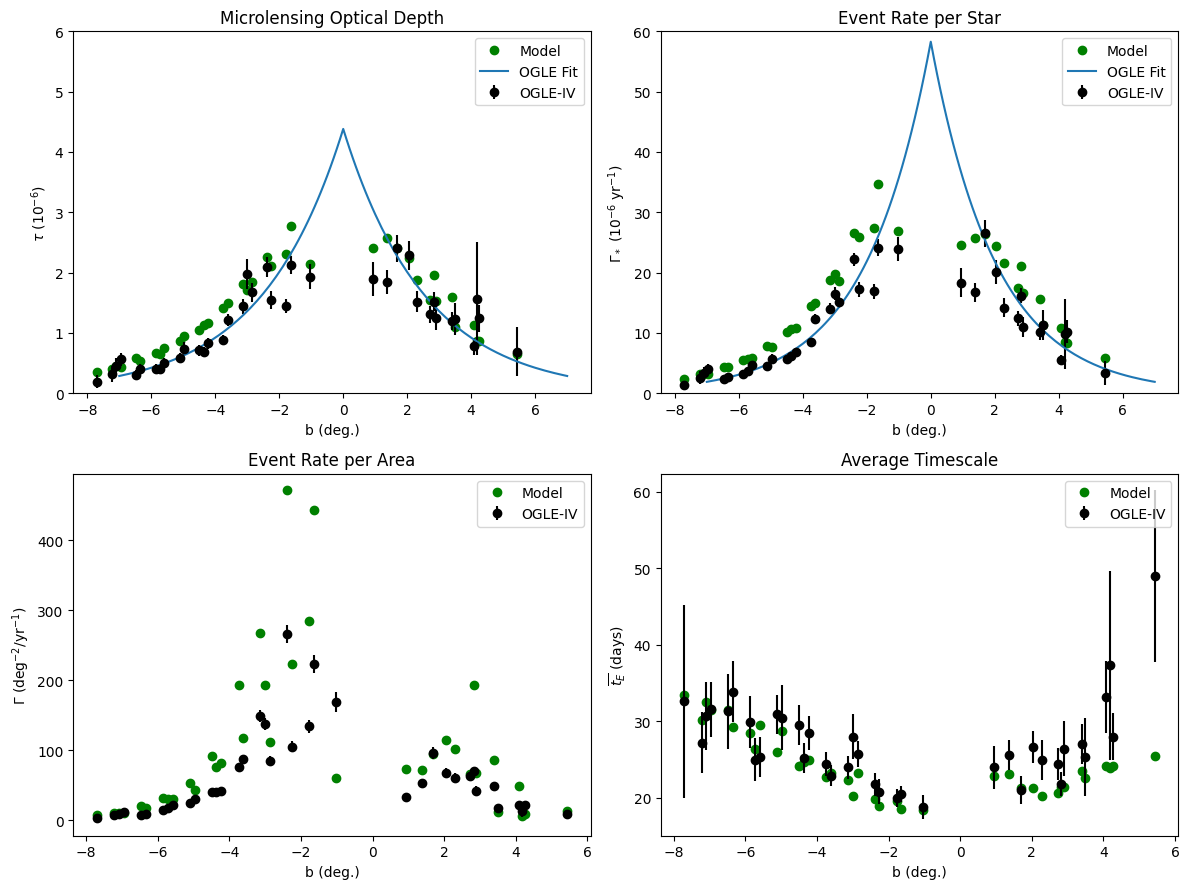

In [30]:
b_pts = np.arange(-7,7.0001,0.1)
def tau_fit(b):
    return 1.36 * np.exp(0.39*(3-abs(b)))
def rt_fit(b):
    return 13.4 * np.exp(0.49*(3-abs(b)))

modlab='Model'; oglab='OGLE-IV'
ogle_rates_sel = ogle_rates[ogle_rates['use_for_latdep']]

plt.subplots(nrows=2,ncols=2,figsize=(12,9))
plt.subplot(221)
plt.title('Microlensing Optical Depth')
plt.plot(sp_dat['b'], sp_dat['avg_tau']*10**6,'go',label=modlab)
plt.errorbar(ogle_rates_sel['GLAT'],ogle_rates_sel['tau'], yerr=ogle_rates_sel['e_tau'],
             linestyle='none',marker='o',c='k',label=oglab)
plt.plot(b_pts, tau_fit(b_pts),label='OGLE Fit')
plt.ylabel(r'$\tau$ (10$^{-6}$)'); plt.xlabel('b (deg.)')
plt.ylim(0,6)
plt.legend()

plt.subplot(222)
plt.title('Event Rate per Star')
plt.plot(sp_dat['b'], sp_dat['eventrate_source']*10**6,'go',label=modlab)
plt.errorbar(ogle_rates_sel['GLAT'],ogle_rates_sel['gam'], yerr=ogle_rates_sel['e_gam'],
             linestyle='none',marker='o',c='k',label=oglab)
plt.plot(b_pts, rt_fit(b_pts),label='OGLE Fit')
plt.ylabel(r'$\Gamma_*$ (10$^{-6}$ yr$^{-1}$)'); plt.xlabel('b (deg.)')
plt.ylim(0,60)
plt.legend()

plt.subplot(223)
plt.title('Event Rate per Area')
plt.plot(sp_dat['b'], sp_dat['eventrate_area'],'go',label=modlab)
plt.errorbar(ogle_rates_sel['GLAT'],ogle_rates_sel['gam-deg2'], yerr=ogle_rates_sel['e_gam-deg2'],
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\Gamma$ (deg$^{-2}$/yr$^{-1}$)'); plt.xlabel('b (deg.)')
#plt.ylim(0,60)
plt.legend()

plt.subplot(224)
plt.title('Average Timescale')
plt.plot(sp_dat['b'], sp_dat['avg_t'],'go',label=modlab)
plt.errorbar(ogle_rates_sel['GLAT'],ogle_rates_sel['tE-mean'], yerr=ogle_rates_sel['e_tE-mean'],
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel('$\overline{t_E}$ (days)'); plt.xlabel('b (deg.)')
#plt.ylim(0,60)
plt.tight_layout()
plt.legend()

plt.savefig('figures/ogle_bdep.png')

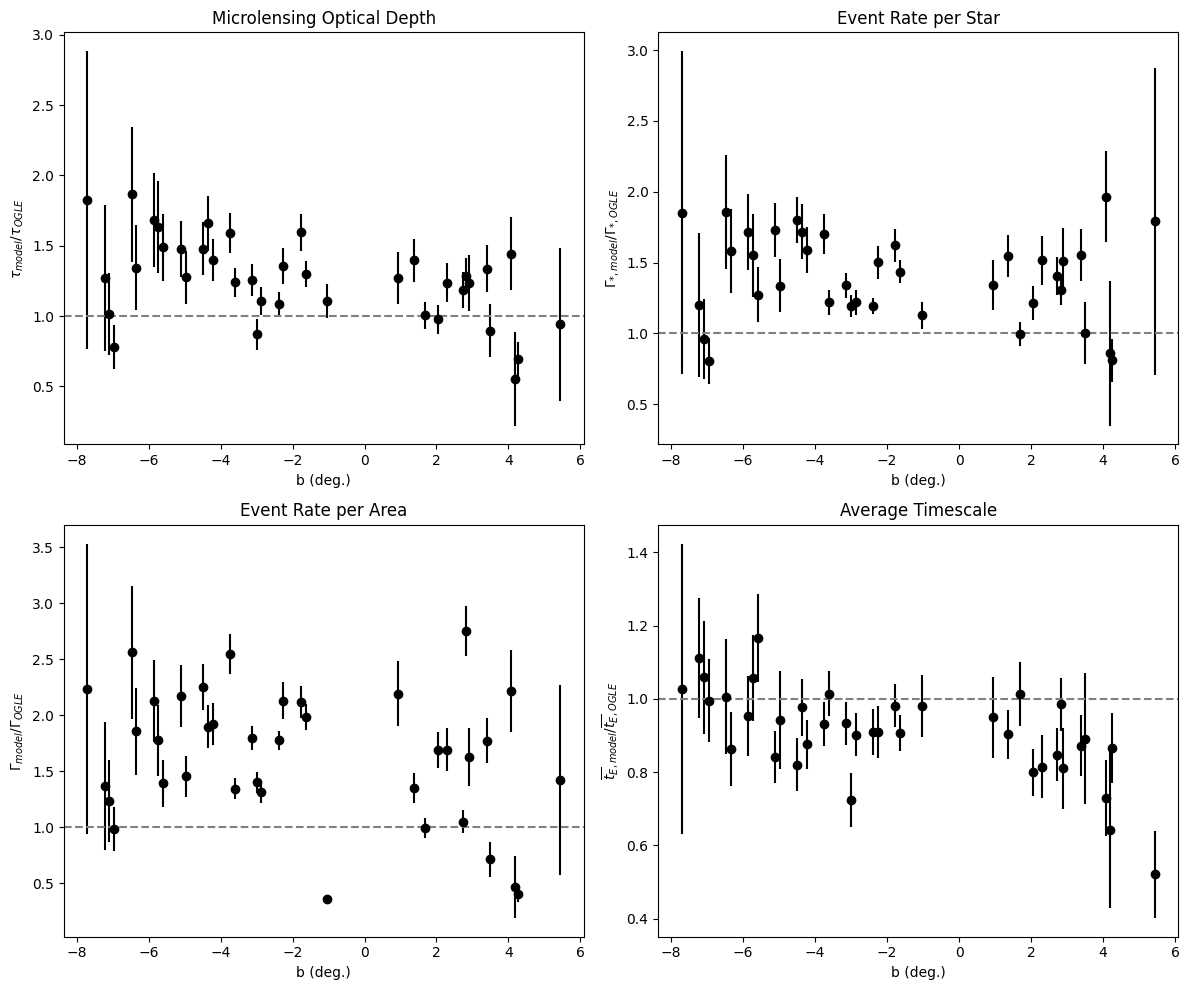

In [32]:
b_pts = np.arange(-7,7.0001,0.1)
def tau_fit(b):
    return 1.36 * np.exp(0.39*(3-abs(b)))
def rt_fit(b):
    return 13.4 * np.exp(0.49*(3-abs(b)))

modlab='Model'; oglab=None

plt.subplots(nrows=2,ncols=2,figsize=(12,10))
plt.subplot(221)
plt.title('Microlensing Optical Depth')
plt.errorbar(sp_dat['b'], np.array(sp_dat['avg_tau'])*10**6/np.array(ogle_rates_sel['tau']), 
             yerr=ogle_rates_sel['e_tau']/ogle_rates_sel['tau']**2*np.array(sp_dat['avg_tau'])*10**6,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\tau_{model}/\tau_{OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.ylim(0,6)
#plt.legend()

plt.subplot(222)
plt.title('Event Rate per Star')
plt.errorbar(ogle_rates_sel['GLAT'],np.array(sp_dat['eventrate_source'])*10**6/np.array(ogle_rates_sel['gam']), 
             yerr=ogle_rates_sel['e_gam']*np.array(sp_dat['eventrate_source'])*10**6/np.array(ogle_rates_sel['gam'])**2,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\Gamma_{*, model}/\Gamma_{*, OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.legend()

plt.subplot(223)
plt.title('Event Rate per Area')
plt.errorbar(ogle_rates_sel['GLAT'],np.array(sp_dat['eventrate_area'])/ogle_rates_sel['gam-deg2'], 
             yerr=ogle_rates_sel['e_gam-deg2']*np.array(sp_dat['eventrate_area'])/ogle_rates_sel['gam-deg2']**2,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\Gamma_{model}/\Gamma_{OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.ylim(-5,20)
#plt.legend()

plt.subplot(224)
plt.title('Average Timescale')
plt.errorbar(ogle_rates_sel['GLAT'],np.array(sp_dat['avg_t'])/ogle_rates_sel['tE-mean'], 
             yerr=ogle_rates_sel['e_tE-mean']*np.array(sp_dat['avg_t'])/ogle_rates_sel['tE-mean']**2,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel('$\overline{t_E}_{, model}/\overline{t_E}_{, OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.ylim(0,60)
#plt.legend()
plt.tight_layout()

plt.savefig('figures/ogle_bdep_ratio.png')